In [2]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from random import randint
from collections import Counter 
import collections
import statistics
import time
from itertools import chain 
import random
import operator
import copy

In [3]:
import networkx as nx

In [4]:
random.seed(42) 

### Importing and exploring data 

In [5]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [6]:
dataset.columns=['Index','Source','Target']

In [7]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [8]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

- categories_all = dictionary of nodes (K) with all associated categories (Values)
- nodes_category = dictionary of nodes (K) with just one category (Values)
- category_nodes = dictionary of categories (K) with all associated nodes (Values)

In [9]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [20]:
category_file = 'wiki-topcats-categories.txt'

Non filtered categories

In [21]:
categories_all = {v: [] for v in unique_nodes}
no_category = []

with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        
        for node in nodes:
            try:
                categories_all[int(node)].append(category)
            except:
                no_category.append(int(node))

Filtering categories
    1. Take the list of categories by a node
    2. Choose one random category
    3. If node have no category --> None

In [22]:
nodes_category = {}
for n in categories_all.keys():
    try:
        rand_category = random.choice(categories_all[n])
        nodes_category[n] = rand_category
    except:
        nodes_category[n] = None

In [23]:
category_nodes = {category:[] for category in set(nodes_category.values())}
for node in nodes_category.keys():
    try:
        category_nodes[nodes_category[node]].append(node)
    except:
        continue

#### Create graph
- in_link = dictionary with all inlinks
- out_link = dictionary with all outlinks

In [24]:
in_links = {v: [] for v in set(dataset.Source)}
out_links = {v: [] for v in set(dataset.Target)}

for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_links[source].append(target)
    out_links[target].append(source)

In [25]:
n_art_outlink = len(out_links)
n_art_inlink = len(in_links)

#### Check if directed

In [26]:
directed = False
for node in in_links:
    if len(set(in_links[node]).intersection(set(out_links[node]))) != 0:
        directed = True
        break
if directed:
    print('Graph is directed')
else:
    print('Graph is undirected')

Graph is directed


In [27]:
# undirected version of the graph
links = in_links.copy()
links.update(out_links)

#### Density
- Having E the number of edges and V the number of the vertices, the density D, for directed graphs, is:
$$D = \frac{|E|}{|V|(|V|-1)}$$

In [28]:
density = (n_edges/(n_nodes*(n_nodes-1)))
avarage = n_edges/n_nodes

print('Graph density is:',density)
print('Graph hyperliks avarage is:',avarage)

Graph density is: 4.9951571365597335e-05
Graph hyperliks avarage is: 4.912337431235573


#### Visualize the nodes' degree distribution

In [29]:
my_len = [] 
for node in links.keys():
    my_len.append(len(links[node]))

# dictionary with degree
node_degree = dict(zip(links.keys(), my_len))
d = Counter(node_degree)

In [30]:
# degree distribution
counter_supp = list()
for i in range(1, max(my_len)):
    counter_supp.append(my_len.count(i))
counter_supp = [c/max(counter_supp) for c in counter_supp]

In [31]:
# cumulative degree ditribution
counter = [0]
for i in range(1, max(my_len)):
    counter.append(counter[-1]+my_len.count(i))
counter = [c/max(counter) for c in counter]

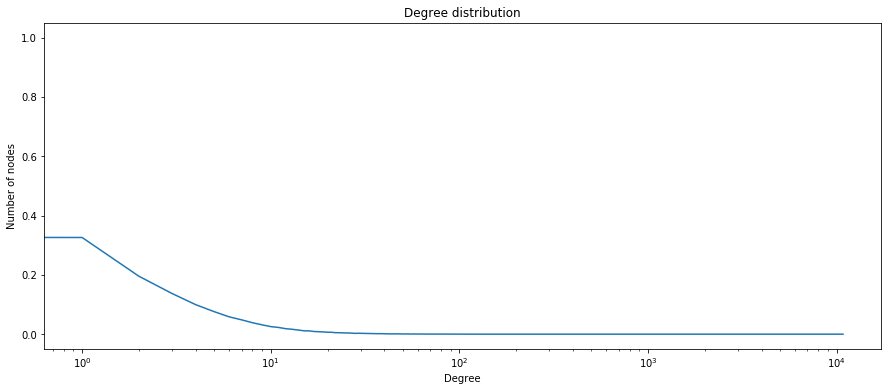

In [39]:
plt.figure(figsize = (15,6))
plt.plot(counter_supp)
plt.xscale('log')
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution')
plt.show()

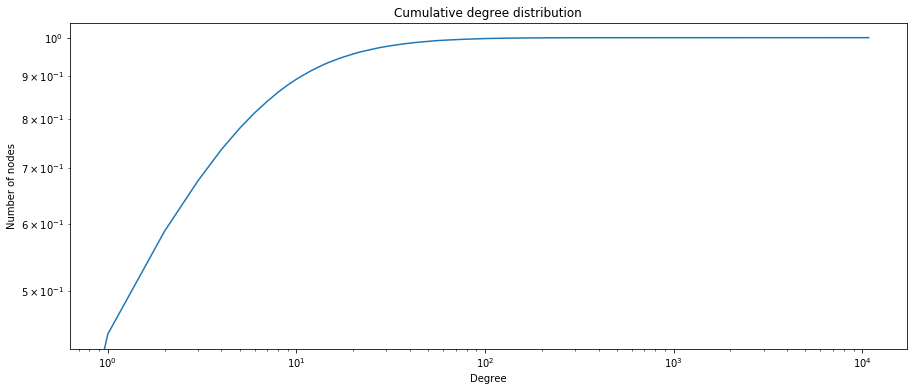

In [38]:
plt.figure(figsize = (15,6))
plt.plot(counter)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Cumulative degree distribution')
plt.show()

### In and out degree

In [16]:
in_d = [] 
for node in in_links.keys():
    in_d.append(len(in_links[node]))

in_degree = dict(zip(in_links.keys(), in_d)) # dictionary with in-degree

In [17]:
out_d = [] 
for node in out_links.keys():
    out_d.append(len(out_links[node]))

out_degree = dict(zip(out_links.keys(), out_d)) # dictionary with out-degree

### Creating the graph with Networkx

In [13]:
G = nx.Graph()

In [14]:
for row in dataset.iterrows():
    G.add_edge(row[1][0], row[1][1], capacity=1)

In [15]:
def add_categories(my_category, G):
    for i in my_category.keys():
        G.nodes[i]['category']=my_category[i]
    return G

In [16]:
add_categories(categories_filtered, G)

### Useful Functions

In [18]:
def explore(node,limit):
   
    ''' This function takes as an input one node and a click limit.
    Limit can be set to None if we don't want any limit.
    The function returns a dictionary where keys are distances and values are all the nodes 
    which are at distance d (key) from the input node'''
    
    # initializing variables
    distance_tree = {}
    explored = set()
    clicks = 1 
    
    # checking if node has at list one outlink
    try:
        out_nodes = set(out_links[node])
    except:
        print('No out-link from', node)
        return distance_tree
    
    '''
    1. We iterate until the new set of out-nodes to explore is non-empty 
    2. For each iteration we only consider unexplored nodes
    3. If the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    4. We update all variables and increase distance by one'''

    while out_nodes != set(): 
        
        if limit != None:
            if clicks > limit+1:        
                return distance_tree
        
        distance_tree[clicks] = out_nodes
        new_out_nodes = set() 
        
        for node in out_nodes: 
            try:
                new_out_nodes = new_out_nodes.union(set(out_links[node])) 
            except:
                continue
        
        explored = explored.union(out_nodes) 
        out_nodes = new_out_nodes.difference(explored)
        clicks += 1 
    
    return distance_tree

In [19]:
def shortest_path (node1,node2):
    
    ''' This function takes in input two nodes and returns the length of the shortest path.
    If node 1 does not have any outlink or if no path is found between node 1 and node 2, None is returned. '''
    
    # exeptions
    if node1 == node2:
        return 0, []
    
    # set of outnodes of node 1
    try:
        out_nodes = set(out_links[node1]) 
    except:
        print('No out-link from', node1)
        return 'Inf', []
    
    # initializing explored nodes set and minimum distance
    explored = set() 
    clicks = 1
    parents =  {node : {1:[node1]} for node in out_nodes}
    
    ''' ITERATIONS: we iterate until we find node 2. In the case in which we have not found node 2 
    but we don't have any new node to explore, we assume the two nodes are disconnected.
    
    1. We check the new set of out-nodes to explore is non-empty 
    2. We iterate through unexplored nodes
    3. If the node is a key in out_links, we add the set of nodes associated to it to the 
    new set of nodes in order to proceed with exploration
    4. In order to retrieve the actual set of nodes met to get from node1 to node2,
    for each explored node we save its parent (or parents) at each iteration and retrace the path
    backwards from node2 to node 1.'''
   
    while node2 not in parents.keys(): 
        clicks += 1 
        
        if out_nodes != set(): 
            new_out_nodes = set() 

            for node in out_nodes:  
                try:
                    new_out_nodes = new_out_nodes.union(set(out_links[node]))
                    for new_node in out_links[node]:
                        if new_node in parents.keys():
                            if clicks in parents[new_node]:
                                parents[new_node][clicks].append(node)
                            else:
                                parents[new_node].update({clicks:[node]})
                        else:
                            parents[new_node] = {clicks:[node]}
                except:
                    continue

            explored = explored.union(out_nodes)
            out_nodes = new_out_nodes.difference(explored) 
    
        else: 
            print('No path found')
            return 'Inf', []
    
    path = [node2]
    while path[-1] != node1:
        path = get_reversed_path(parents,clicks,node2)
    
    return clicks, [node2]+path

In [20]:
def get_reversed_path(parents, dist, node):
    
    '''we iterate backwards from node2 to node1 through the parents dictionary until we find node1 
    at distance "clicks" from node 2. In the case of branched path we explore them randomly untile we 
    find the one we are interested in.'''
    
    path = []
    for i in reversed(range(1,dist+1)):
        parent_list = parents[node][i]
        if len(parent_list) > 1:
            index = random.randint(0,len(parent_list)-1)
            parent = parent_list[index]
        else:
            parent = parent_list[0]
        path.append(parent)
        node = parent
    
    return path

In [27]:
node2 = 1161925
node3 = 134

In [28]:
sp,path = shortest_path(node3,node2)
print('Shortest path between', node3, 'and', node2, 'is', path, 'which requires', sp, 'clicks')

Shortest path between 134 and 1161925 is [1161925, 1056157, 1165599, 1061485, 134] which requires 4 clicks


In [29]:
tree = explore(node3,None)
print('Exploration tree of node', node3, 'has max distance', max(tree.keys()))

Exploration tree of node 134 has max distance 15
